<a href="https://colab.research.google.com/github/parlange/AutoML/blob/master/simulator_z.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Download the Galaxy10_DECals Dataset


In [1]:
!wget https://astro.utoronto.ca/~hleung/shared/Galaxy10/Galaxy10_DECals.h5 -O Galaxy10_DECals.h5 --no-check-certificate

--2024-06-24 01:51:37--  https://astro.utoronto.ca/~hleung/shared/Galaxy10/Galaxy10_DECals.h5
Resolving astro.utoronto.ca (astro.utoronto.ca)... 142.1.217.162
Connecting to astro.utoronto.ca (astro.utoronto.ca)|142.1.217.162|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://www.astro.utoronto.ca/~hleung/shared/Galaxy10/Galaxy10_DECals.h5 [following]
--2024-06-24 01:51:37--  https://www.astro.utoronto.ca/~hleung/shared/Galaxy10/Galaxy10_DECals.h5
Resolving www.astro.utoronto.ca (www.astro.utoronto.ca)... 128.100.89.92
Connecting to www.astro.utoronto.ca (www.astro.utoronto.ca)|128.100.89.92|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2735267419 (2.5G)
Saving to: ‘Galaxy10_DECals.h5’

Galaxy10_DECals.h5  100%[===================>]   2.55G  65.5MB/s    in 30s     

2024-06-24 01:52:07 (88.3 MB/s) - ‘Galaxy10_DECals.h5’ saved [2735267419/2735267419]



## Sample subset of Galaxy10

In [2]:
import h5py
import numpy as np

# Load the images, labels, and redshifts from the file
with h5py.File('Galaxy10_DECals.h5', 'r') as F:
    images = np.array(F['images'])
    typ = np.array(F['ans'])
    redshifts = np.array(F['redshift'])  # Ensure 'redshift' dataset exists

# Number of images to save per type
num_images_per_type = 10

# Lists to store selected images, types, and redshifts
selected_images = []
selected_types = []
selected_redshifts = []

# Function to select the first images of each type
def select_first_images_by_type(images, typ, redshifts, num_images_per_type):
    unique_types = np.unique(typ)

    for t in unique_types:
        type_indices = np.where(typ == t)[0]
        selected_indices = type_indices[:num_images_per_type]

        selected_images.extend(images[selected_indices])
        selected_types.extend([t] * num_images_per_type)
        selected_redshifts.extend(redshifts[selected_indices])

# Select the first n images of each type
select_first_images_by_type(images, typ, redshifts, num_images_per_type)

# Convert to numpy arrays
selected_images = np.array(selected_images)
selected_types = np.array(selected_types)
selected_redshifts = np.array(selected_redshifts)

# Save the selected images, types, and redshifts to a new HDF5 file
output_file_path = 'Galaxy10_DECals10samples.h5'
with h5py.File(output_file_path, 'w') as F:
    F.create_dataset('images', data=selected_images)
    F.create_dataset('ans', data=selected_types)
    F.create_dataset('redshift', data=selected_redshifts)

print(f"Saved the first {num_images_per_type} images of each type to {output_file_path}")


Saved the first 10 images of each type to Galaxy10_DECals10samples.h5


## Installing Libraries

In [3]:
!pip install lenstronomy
!pip install pyHalo
!pip install colossus
!pip install opencv-python
!pip install mcfit

## Importing Libraries

In [4]:
from tqdm import tqdm
import copy
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import h5py
import random

## Opening the dataset

In [5]:
# Load real galaxies
with h5py.File('Galaxy10_DECals10samples.h5', 'r') as F:
    images = np.array(F['images'])
    typ = np.array(F['ans'])
    z = np.array(F['redshift'])

images_ref = images
z_ref = z

# Filter by redshift
indx_img_zp1 = np.where(z_ref < 1)
img_zp1 = images_ref[indx_img_zp1]

## Counting the images from 10 types of galaxies


In [6]:
# Get the total number of images
total_images = len(images)
print(f"Total number of images: {total_images}")

# Count the number of images for each type
unique_types, counts = np.unique(typ, return_counts=True)
for t, count in zip(unique_types, counts):
    print(f"Type {t}: {count} images")


Total number of images: 100
Type 0: 10 images
Type 1: 10 images
Type 2: 10 images
Type 3: 10 images
Type 4: 10 images
Type 5: 10 images
Type 6: 10 images
Type 7: 10 images
Type 8: 10 images
Type 9: 10 images


## Import lenstronomy


In [7]:
import os
import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import h5py
import random
from tqdm import tqdm
from scipy.ndimage import gaussian_filter
from astropy.cosmology import FlatLambdaCDM
from lenstronomy.LightModel.Profiles.gaussian import GaussianEllipse
from lenstronomy.SimulationAPI.ObservationConfig.DES import DES
from lenstronomy.SimulationAPI.ObservationConfig.LSST import LSST
from lenstronomy.SimulationAPI.ObservationConfig.Roman import Roman
from lenstronomy.SimulationAPI.ObservationConfig.Euclid import Euclid
from pyHalo.preset_models import CDM, ULDM, WDM
from pyHalo.Halos.lens_cosmo import LensCosmo
from pyHalo.single_realization import SingleHalo
from lenstronomy.LensModel.Profiles.cnfw import CNFW
from lenstronomy.LensModel.Profiles.nfw import NFW
from lenstronomy.LensModel.lens_model import LensModel
from lenstronomy.LensModel.lens_model_extensions import LensModelExtensions
import lenstronomy.Util.data_util as data_util
import lenstronomy.Util.util as util
import lenstronomy.Plots.plot_util as plot_util
from lenstronomy.SimulationAPI.sim_api import SimAPI


## Define cosmology, telescopes, bands, PSF, coadd or survey_mode

In [8]:
# Gaussian Ellipse instance
gauss = GaussianEllipse()

# Instrument configurations
instruments = {
    'Euclid': {
        'g_band': Euclid(band='VIS', psf_type='GAUSSIAN', coadd_years=6).kwargs_single_band(),
        'r_band': Euclid(band='VIS', psf_type='GAUSSIAN', coadd_years=6).kwargs_single_band(),
        'i_band': Euclid(band='VIS', psf_type='GAUSSIAN', coadd_years=6).kwargs_single_band()
    },
    'DES': {
        'g_band': DES(band='g', psf_type='GAUSSIAN', coadd_years=3).kwargs_single_band(),
        'r_band': DES(band='r', psf_type='GAUSSIAN', coadd_years=3).kwargs_single_band(),
        'i_band': DES(band='i', psf_type='GAUSSIAN', coadd_years=3).kwargs_single_band()
    },
    'LSST': {
        'g_band': LSST(band='g', psf_type='GAUSSIAN', coadd_years=10).kwargs_single_band(),
        'r_band': LSST(band='r', psf_type='GAUSSIAN', coadd_years=10).kwargs_single_band(),
        'i_band': LSST(band='i', psf_type='GAUSSIAN', coadd_years=10).kwargs_single_band()
    },
    'Roman': {
        'g_band': Roman(band='F062', psf_type='PIXEL', survey_mode='wide_area').kwargs_single_band(),
        'r_band': Roman(band='F106', psf_type='PIXEL', survey_mode='wide_area').kwargs_single_band(),
        'i_band': Roman(band='F184', psf_type='PIXEL', survey_mode='wide_area').kwargs_single_band()
    }
}

## Define image to ensure image size


In [9]:
# Function to ensure image is 64x64
def ensure_image_size(image, target_size=(64, 64)):
    if image.shape != target_size:
        image = cv2.resize(image, target_size, interpolation=cv2.INTER_AREA)
    return image


## No-Substructure functions


In [10]:
# Define cosmology
cosmo = FlatLambdaCDM(H0=70, Om0=0.3, Ob0=0.0)

# The simulate_no_sub function should also include the cosmo object to maintain consistency
# with simulate_cdm, even though it does not include substructure

def simulate_no_sub(image_galaxy, Ens, source_pos_xx, source_pos_yy, source_ang, kwargs_g_band, zlens=0.5, zsource=1.0):
    kwargs_lens_main = {'theta_E': Ens, 'e1': 0, 'e2': 0, 'center_x': 0, 'center_y': 0}
    kwargs_shear = {'gamma1': 0.05, 'gamma2': 0}
    lens_model_macro = ['SIE', 'SHEAR']
    kwargs_lens = [kwargs_lens_main, kwargs_shear]

    kwargs_model_physical = {
        'lens_model_list': lens_model_macro,
        'lens_redshift_list': [zlens, zlens],  # Note: same zlens for both SIE and SHEAR
        'lens_light_model_list': ['SERSIC_ELLIPSE', 'SERSIC_ELLIPSE'],
        'source_light_model_list': ['INTERPOL'],
        'source_redshift_list': [zsource],
        'cosmo': cosmo,
        'z_source_convention': 2.5,
        'z_source': 2.5
    }

    numpix = 64
    kwargs_numerics = {'point_source_supersampling_factor': 1}
    sim_g = SimAPI(numpix=numpix, kwargs_single_band=kwargs_g_band, kwargs_model=kwargs_model_physical)
    imSim_g = sim_g.image_model_class(kwargs_numerics)

    source_scale = 0.015
    X, Y = source_pos_xx, source_pos_yy
    image_data_g = image_galaxy.astype(float)
    median_g = np.median(image_galaxy[:50, :50].astype(float))
    image_data_g -= median_g

    kwargs_lens_light_mag_g = [
        {'magnitude': 40, 'R_sersic': 0.4, 'n_sersic': 2.3, 'e1': 0, 'e2': 0.05, 'center_x': 0, 'center_y': 0},
        {'magnitude': 40, 'R_sersic': 1.5, 'n_sersic': 1.2, 'e1': 0, 'e2': 0.3, 'center_x': 0, 'center_y': 0}
    ]
    kwargs_source_mag_g = [
        {'magnitude': np.random.normal(16, 0.1), 'image': image_data_g, 'scale': source_scale, 'phi_G': source_ang, 'center_x': X, 'center_y': Y}
    ]

    kwargs_lens_light_g, kwargs_source_g, _ = sim_g.magnitude2amplitude(kwargs_lens_light_mag_g, kwargs_source_mag_g)
    image_g = imSim_g.image(kwargs_lens, kwargs_source_g, kwargs_lens_light_g)
    image_g += sim_g.noise_for_model(model=image_g)

    return image_g

def simulator_model_no_sub(img_zp1, kwargs_g_band, zlens, zsource):
    index = np.random.randint(0, len(img_zp1))
    Ens, source_pos_xx, source_pos_yy, source_ang = np.random.normal(1.5, .5), np.random.uniform(-0.4, 0.4), np.random.uniform(-0.4, 0.4), np.random.uniform(-np.pi, np.pi)
    result = gaussian_filter(img_zp1[index][:, :, 0], sigma=3)
    sim = simulate_no_sub(result, Ens, source_pos_xx, source_pos_yy, source_ang, kwargs_g_band, zlens, zsource)
    return np.absolute(sim)

def simulate_image_no_sub(img_zp1, kwargs_g_band, zlens, zsource):
    sim = simulator_model_no_sub(img_zp1, kwargs_g_band, zlens, zsource)
    return np.array(sim).clip(min=0)


## ULDM simulation functions


In [38]:
import numpy as np
from scipy.ndimage import gaussian_filter
from pyHalo.preset_models import ULDM
from pyHalo.Halos.lens_cosmo import LensCosmo
from pyHalo.concentration_models import preset_concentration_models
from lenstronomy.SimulationAPI.sim_api import SimAPI
from astropy.cosmology import FlatLambdaCDM

def simulate_uldm(image_galaxy, Ens, source_pos_xx, source_pos_yy, source_ang, axion_mass, kwargs_g_band, zlens=0.5, zsource=1.0):
    lc = LensCosmo(zlens, zsource)
    model, kwargs_concentration_model = preset_concentration_models('LAROCHE2022')

    realizationsULDM = ULDM(zlens, zsource, log10_m_uldm=axion_mass, uldm_plaw=1./3, flucs=False)
    astropy_instance = realizationsULDM.astropy_instance

    lens_model_list, lens_redshift_array, kwargs_halos, numerical_deflection_class = realizationsULDM.lensing_quantities()

    if numerical_deflection_class is not None:
        R_values = numerical_deflection_class.radii
        numerical_deflection_class.radii = np.maximum(R_values, 1e-3)

    kwargs_lens_main = {'theta_E': Ens, 'e1': 0, 'e2': 0, 'center_x': 0, 'center_y': 0}
    kwargs_shear = {'gamma1': 0.05, 'gamma2': 0}
    lens_model_macro = ['SIE', 'SHEAR']
    kwargs_macromodel = [kwargs_lens_main, kwargs_shear]

    log10_m_uldm_list = [-21.0, -20.5, -20]
    for log10_m_uldm in log10_m_uldm_list:
        m22 = 10**(log10_m_uldm + 22)
        log_mc = np.log10(1.6e10 * m22**(-4/3))
        kwargs_concentration_model['log_mc'] = log_mc
        kwargs_concentration_model['scatter'] = False
        concentration_model = model(lc.cosmo.astropy, **kwargs_concentration_model)
        kwargs_density_profile = {
            'log10_m_uldm': log10_m_uldm,
            'scale_nfw': True,
            'uldm_plaw': 1./3,
            'evaluate_mc_at_zlens': True
        }
        kwargs_halos.append({
            'truncation_model': None,
            'concentration_model': concentration_model,
            'kwargs_density_profile': kwargs_density_profile
        })

    lens_model_list_full = lens_model_macro + lens_model_list
    lens_redshift_list_full = [zlens, zlens] + list(lens_redshift_array)
    kwargs_lens_full = kwargs_macromodel + kwargs_halos

    kwargs_model_physical = {
        'lens_model_list': lens_model_list_full,
        'lens_redshift_list': lens_redshift_list_full,
        'lens_light_model_list': ['SERSIC_ELLIPSE', 'SERSIC_ELLIPSE'],
        'source_light_model_list': ['INTERPOL'],
        'source_redshift_list': [zsource],
        'cosmo': astropy_instance,
        'z_source_convention': 2.5,
        'z_source': zsource
    }

    numpix = 64
    kwargs_numerics = {'point_source_supersampling_factor': 1}
    sim_g = SimAPI(numpix=numpix, kwargs_single_band=kwargs_g_band, kwargs_model=kwargs_model_physical)
    imSim_g = sim_g.image_model_class(kwargs_numerics)

    source_scale = 0.015
    X, Y = source_pos_xx, source_pos_yy
    image_data_g = image_galaxy.astype(float)
    median_g = np.median(image_galaxy[:50, :50].astype(float))
    image_data_g -= median_g

    kwargs_lens_light_mag_g = [
        {'magnitude': 40, 'R_sersic': 0.4, 'n_sersic': 2.3, 'e1': 0, 'e2': 0.05, 'center_x': 0, 'center_y': 0},
        {'magnitude': 40, 'R_sersic': 1.5, 'n_sersic': 1.2, 'e1': 0, 'e2': 0.3, 'center_x': 0, 'center_y': 0}
    ]
    kwargs_source_mag_g = [
        {'magnitude': np.random.normal(16, 0.1), 'image': image_data_g, 'scale': source_scale, 'phi_G': source_ang, 'center_x': X, 'center_y': Y}
    ]

    kwargs_lens_light_g, kwargs_source_g, _ = sim_g.magnitude2amplitude(kwargs_lens_light_mag_g, kwargs_source_mag_g)
    image_g = imSim_g.image(kwargs_lens_full, kwargs_source_g, kwargs_lens_light_g)
    image_g += sim_g.noise_for_model(model=image_g)

    return image_g, realizationsULDM

def simulator_model_uldm(img_zp1, axion_mass, kwargs_g_band, zlens, zsource):
    index = np.random.randint(0, len(img_zp1))
    Ens, source_pos_xx, source_pos_yy, source_ang = np.random.normal(1.5, .5), np.random.uniform(-0.4, 0.4), np.random.uniform(-0.4, 0.4), np.random.uniform(-np.pi, np.pi)
    result = gaussian_filter(img_zp1[index][:, :, 0], sigma=3)
    sim, realizationsULDM = simulate_uldm(result, Ens, source_pos_xx, source_pos_yy, source_ang, axion_mass, kwargs_g_band, zlens, zsource)
    return np.absolute(sim)

def simulate_image_uldm(img_zp1, kwargs_g_band, zlens, zsource, axion_mass=-21.5):
    sim = simulator_model_uldm(img_zp1, axion_mass, kwargs_g_band, zlens, zsource)
    return np.array(sim).clip(min=0)


## Warm dark matter simulations


In [39]:
import numpy as np
from scipy.ndimage import gaussian_filter
from pyHalo.preset_models import WDM
from lenstronomy.SimulationAPI.sim_api import SimAPI
from astropy.cosmology import FlatLambdaCDM

def simulate_wdm(image_galaxy, Ens, source_pos_xx, source_pos_yy, source_ang, log10_half_mode_mass, kwargs_g_band, zlens=0.5, zsource=1.0):
    kwargs_concentration_model_subhalos = {'scatter': True}
    kwargs_concentration_model_fieldhalos = {'scatter': True}
    realizationWDM = WDM(zlens, zsource, log_mc=log10_half_mode_mass, cone_opening_angle_arcsec=8, log_mlow=6.0,
                         geometry_type='CYLINDER', sigma_sub=0.1,
                         kwargs_concentration_model_subhalos=kwargs_concentration_model_subhalos,
                         kwargs_concentration_model_fieldhalos=kwargs_concentration_model_fieldhalos)
    astropy_instance = realizationWDM.astropy_instance

    lens_model_list, lens_redshift_array, kwargs_halos, numerical_deflection_class = realizationWDM.lensing_quantities()

    if numerical_deflection_class is not None:
        R_values = numerical_deflection_class.radii
        numerical_deflection_class.radii = np.maximum(R_values, 1e-3)

    kwargs_lens_main = {'theta_E': Ens, 'e1': 0, 'e2': 0, 'center_x': 0, 'center_y': 0}
    kwargs_shear = {'gamma1': 0.05, 'gamma2': 0}
    lens_model_macro = ['SIE', 'SHEAR']
    kwargs_macromodel = [kwargs_lens_main, kwargs_shear]

    lens_model_list_full = lens_model_macro + lens_model_list
    lens_redshift_list_full = [zlens, zlens] + list(lens_redshift_array)
    kwargs_lens_full = kwargs_macromodel + kwargs_halos

    kwargs_model_physical = {
        'lens_model_list': lens_model_list_full,
        'lens_redshift_list': lens_redshift_list_full,
        'lens_light_model_list': ['SERSIC_ELLIPSE', 'SERSIC_ELLIPSE'],
        'source_light_model_list': ['INTERPOL'],
        'source_redshift_list': [zsource],
        'cosmo': astropy_instance,
        'z_source_convention': 2.5,
        'z_source': zsource
    }

    numpix = 64
    kwargs_numerics = {'point_source_supersampling_factor': 1}
    sim_g = SimAPI(numpix=numpix, kwargs_single_band=kwargs_g_band, kwargs_model=kwargs_model_physical)
    imSim_g = sim_g.image_model_class(kwargs_numerics)

    source_scale = 0.015
    X, Y = source_pos_xx, source_pos_yy
    image_data_g = image_galaxy.astype(float)
    median_g = np.median(image_galaxy[:50, :50].astype(float))
    image_data_g -= median_g

    kwargs_lens_light_mag_g = [
        {'magnitude': 40, 'R_sersic': 0.4, 'n_sersic': 2.3, 'e1': 0, 'e2': 0.05, 'center_x': 0, 'center_y': 0},
        {'magnitude': 40, 'R_sersic': 1.5, 'n_sersic': 1.2, 'e1': 0, 'e2': 0.3, 'center_x': 0, 'center_y': 0}
    ]
    kwargs_source_mag_g = [
        {'magnitude': np.random.normal(16, 0.1), 'image': image_data_g, 'scale': source_scale, 'phi_G': source_ang, 'center_x': X, 'center_y': Y}
    ]

    kwargs_lens_light_g, kwargs_source_g, _ = sim_g.magnitude2amplitude(kwargs_lens_light_mag_g, kwargs_source_mag_g)
    image_g = imSim_g.image(kwargs_lens_full, kwargs_source_g, kwargs_lens_light_g)
    image_g += sim_g.noise_for_model(model=image_g)

    return image_g, realizationWDM

def simulator_model_wdm(img_zp1, log10_half_mode_mass, kwargs_g_band, zlens, zsource):
    index = np.random.randint(0, len(img_zp1))
    Ens, source_pos_xx, source_pos_yy, source_ang = np.random.normal(1.5, .5), np.random.uniform(-0.4, 0.4), np.random.uniform(-0.4, 0.4), np.random.uniform(-np.pi, np.pi)
    result = gaussian_filter(img_zp1[index][:, :, 0], sigma=3)
    sim, realizationWDM = simulate_wdm(result, Ens, source_pos_xx, source_pos_yy, source_ang, log10_half_mode_mass, kwargs_g_band, zlens, zsource)
    return np.absolute(sim)

def simulate_image_wdm(img_zp1, kwargs_g_band, zlens, zsource, log10_half_mode_mass=7.0):
    sim = simulator_model_wdm(img_zp1, log10_half_mode_mass, kwargs_g_band, zlens, zsource)
    return np.array(sim).clip(min=0)


## CDM simulation functions


In [36]:
import numpy as np
from scipy.ndimage import gaussian_filter
from pyHalo.preset_models import CDM
from lenstronomy.SimulationAPI.sim_api import SimAPI
from astropy.cosmology import FlatLambdaCDM

def simulate_cdm(image_galaxy, Ens, source_pos_xx, source_pos_yy, source_ang, kwargs_g_band, zlens=0.5, zsource=1.0):
    kwargs_lens_main = {'theta_E': Ens, 'e1': 0, 'e2': 0, 'center_x': 0, 'center_y': 0}
    kwargs_shear = {'gamma1': 0.05, 'gamma2': 0}
    lens_model_macro = ['SIE', 'SHEAR']
    kwargs_lens = [kwargs_lens_main, kwargs_shear]

    realizationsCDM = CDM(zlens, zsource, cone_opening_angle_arcsec=10)
    lens_model_list, lens_redshift_array, kwargs_halos, numerical_deflection_class = realizationsCDM.lensing_quantities()
    astropy_instance = realizationsCDM.astropy_instance

    if numerical_deflection_class is not None:
        R_values = numerical_deflection_class.radii
        numerical_deflection_class.radii = np.maximum(R_values, 1e-3)

    lens_model_list_full = lens_model_macro + lens_model_list
    lens_redshift_list_full = [zlens, zlens] + list(lens_redshift_array)
    kwargs_lens_full = kwargs_lens + kwargs_halos

    kwargs_model_physical = {
        'lens_model_list': lens_model_list_full,
        'lens_redshift_list': lens_redshift_list_full,
        'lens_light_model_list': ['SERSIC_ELLIPSE', 'SERSIC_ELLIPSE'],
        'source_light_model_list': ['INTERPOL'],
        'source_redshift_list': [zsource],
        'cosmo': astropy_instance,
        'z_source_convention': 2.5,
        'z_source': zsource
    }

    numpix = 64
    kwargs_numerics = {'point_source_supersampling_factor': 1}
    sim_g = SimAPI(numpix=numpix, kwargs_single_band=kwargs_g_band, kwargs_model=kwargs_model_physical)
    imSim_g = sim_g.image_model_class(kwargs_numerics)

    source_scale = 0.015
    X, Y = source_pos_xx, source_pos_yy
    image_data_g = image_galaxy.astype(float)
    median_g = np.median(image_galaxy[:50, :50].astype(float))
    image_data_g -= median_g

    kwargs_lens_light_mag_g = [
        {'magnitude': 40, 'R_sersic': 0.4, 'n_sersic': 2.3, 'e1': 0, 'e2': 0.05, 'center_x': 0, 'center_y': 0},
        {'magnitude': 40, 'R_sersic': 1.5, 'n_sersic': 1.2, 'e1': 0, 'e2': 0.3, 'center_x': 0, 'center_y': 0}
    ]
    kwargs_source_mag_g = [
        {'magnitude': np.random.normal(16, 0.1), 'image': image_data_g, 'scale': source_scale, 'phi_G': source_ang, 'center_x': X, 'center_y': Y}
    ]

    kwargs_lens_light_g, kwargs_source_g, _ = sim_g.magnitude2amplitude(kwargs_lens_light_mag_g, kwargs_source_mag_g)
    image_g = imSim_g.image(kwargs_lens_full, kwargs_source_g, kwargs_lens_light_g)
    image_g += sim_g.noise_for_model(model=image_g)

    return image_g, realizationsCDM

def simulator_model_cdm(img_zp1, kwargs_g_band, zlens, zsource):
    index = np.random.randint(0, len(img_zp1))
    Ens, source_pos_xx, source_pos_yy, source_ang = np.random.normal(1.5, .5), np.random.uniform(-0.4, 0.4), np.random.uniform(-0.4, 0.4), np.random.uniform(-np.pi, np.pi)
    result = gaussian_filter(img_zp1[index][:, :, 0], sigma=3)
    sim, realizationsCDM = simulate_cdm(result, Ens, source_pos_xx, source_pos_yy, source_ang, kwargs_g_band, zlens, zsource)
    return np.absolute(sim)

def simulate_image_cdm(img_zp1, kwargs_g_band, zlens, zsource):
    sim = simulator_model_cdm(img_zp1, kwargs_g_band, zlens, zsource)
    return np.array(sim).clip(min=0)


## Simulate

In [41]:
from tqdm import tqdm
import os
import numpy as np

# Function to save numpy arrays
def save_list_as_numpy_array(lst, path):
    os.makedirs(os.path.dirname(path), exist_ok=True)
    np_array = np.array(lst)
    np.save(path, np_array)

# Generate datasets for each instrument
data_path_base = '/content/'

for instrument_name, instrument_config in instruments.items():
    data_path = f'{data_path_base}/{instrument_name}'

    data = []
    labels = []

    for kind in ('train', 'test'):
        num_images_no_sub = 1
        num_images_uldm = 1
        num_images_wdm = 1
        num_images_cdm = 1

        for i in tqdm(range(num_images_no_sub), desc=f'{instrument_name} {kind} - No sub'):
            index = np.random.randint(0, len(img_zp1))
            zlens_value = z_ref[index]
            zsource_value = z_ref[index] + 0.5

            # No substructure simulation
            no_sub = simulate_image_no_sub(img_zp1, instrument_config['g_band'], zlens_value, zsource_value)
            no_sub = ensure_image_size(no_sub)
            no_sub = no_sub / np.max(no_sub)
            data.append(no_sub.reshape(64, 64))
            labels.append([1, 0, 0, 0])  # No substructure label

        for i in tqdm(range(num_images_uldm), desc=f'{instrument_name} {kind} - ULDM'):
            try:
                uldm = simulate_image_uldm(img_zp1, instrument_config['g_band'], zlens_value, zsource_value)
                uldm = ensure_image_size(uldm)
                uldm = uldm / np.max(uldm)
                data.append(uldm.reshape(64, 64))
                labels.append([0, 1, 0, 0])  # ULDM label
            except Exception as e:
                print(f"Error in ULDM simulation for {instrument_name} {kind}: {e}")

        for i in tqdm(range(num_images_wdm), desc=f'{instrument_name} {kind} - WDM'):
            try:
                wdm = simulate_image_wdm(img_zp1, instrument_config['g_band'], zlens_value, zsource_value)
                wdm = ensure_image_size(wdm)
                wdm = wdm / np.max(wdm)
                data.append(wdm.reshape(64, 64))
                labels.append([0, 0, 1, 0])  # WDM label
            except Exception as e:
                print(f"Error in WDM simulation for {instrument_name} {kind}: {e}")

        for i in tqdm(range(num_images_cdm), desc=f'{instrument_name} {kind} - CDM'):
            try:
                cdm = simulate_image_cdm(img_zp1, instrument_config['g_band'], zlens_value, zsource_value)
                cdm = ensure_image_size(cdm)
                cdm = cdm / np.max(cdm)
                data.append(cdm.reshape(64, 64))
                labels.append([0, 0, 0, 1])  # CDM label
            except Exception as e:
                print(f"Error in CDM simulation for {instrument_name} {kind}: {e}")

        save_list_as_numpy_array(data, f'{data_path}/data_{kind}.npy')
        save_list_as_numpy_array(labels, f'{data_path}/labels_{kind}.npy')
        data.clear()
        labels.clear()

# Load and count the number of images in train and test datasets for each instrument
print("\n")
for instrument_name in instruments.keys():
    data_path = f'{data_path_base}/{instrument_name}'

    data_train = np.load(f'{data_path}/data_train.npy')
    data_test = np.load(f'{data_path}/data_test.npy')

    num_images_train = len(data_train)
    num_images_test = len(data_test)

    print(f"Number of images in the train dataset for {instrument_name}:", num_images_train)
    print(f"Number of images in the test dataset for {instrument_name}:", num_images_test)



Euclid train - Generating images: 100%|██████████| 4/4 [00:05<00:00,  1.33s/it]


Error in CDM simulation for Euclid train: R = 0.00e+00 is too small (min. R = 1.00e-03)



Euclid test - Generating images:  50%|█████     | 2/4 [00:00<00:00,  5.24it/s]

Error in ULDM simulation for Euclid test: R = 0.00e+00 is too small (min. R = 1.00e-03)



Euclid test - Generating images:  75%|███████▌  | 3/4 [00:00<00:00,  4.66it/s]

Error in WDM simulation for Euclid test: R = 0.00e+00 is too small (min. R = 1.00e-03)



Euclid test - Generating images: 100%|██████████| 4/4 [00:00<00:00,  4.58it/s]


Error in CDM simulation for Euclid test: R = 0.00e+00 is too small (min. R = 1.00e-03)



DES train - Generating images: 100%|██████████| 4/4 [00:04<00:00,  1.03s/it]


Error in CDM simulation for DES train: R = 0.00e+00 is too small (min. R = 1.00e-03)



DES test - Generating images: 100%|██████████| 4/4 [00:06<00:00,  1.50s/it]

LSST train - Generating images: 100%|██████████| 4/4 [00:10<00:00,  2.69s/it]

LSST test - Generating images: 100%|██████████| 4/4 [00:04<00:00,  1.09s/it]


Error in CDM simulation for LSST test: R = 0.00e+00 is too small (min. R = 1.00e-03)



Roman train - Generating images: 100%|██████████| 4/4 [00:07<00:00,  1.78s/it]

Roman test - Generating images: 100%|██████████| 4/4 [00:06<00:00,  1.72s/it]



Number of images in the train dataset for Euclid: 3
Number of images in the test dataset for Euclid: 1
Number of images in the train dataset for DES: 3
Number of images in the test dataset for DES: 4
Number of images in the train dataset for LSST: 4
Number of images in the test dataset for LSST: 3
Number of images in the train dataset for Roman: 4
Number of images in the test dataset for Roman: 4


## Load from npy and display, including DECaLS galaxies for reference


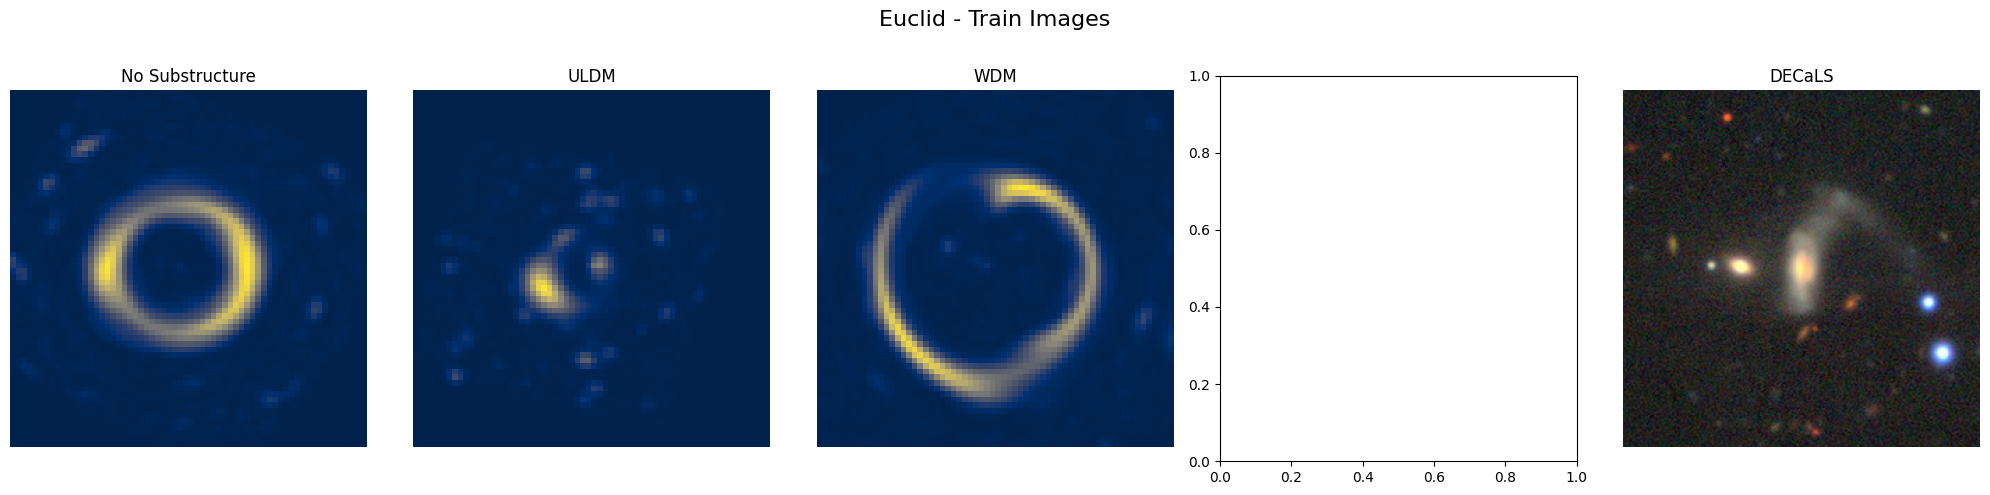

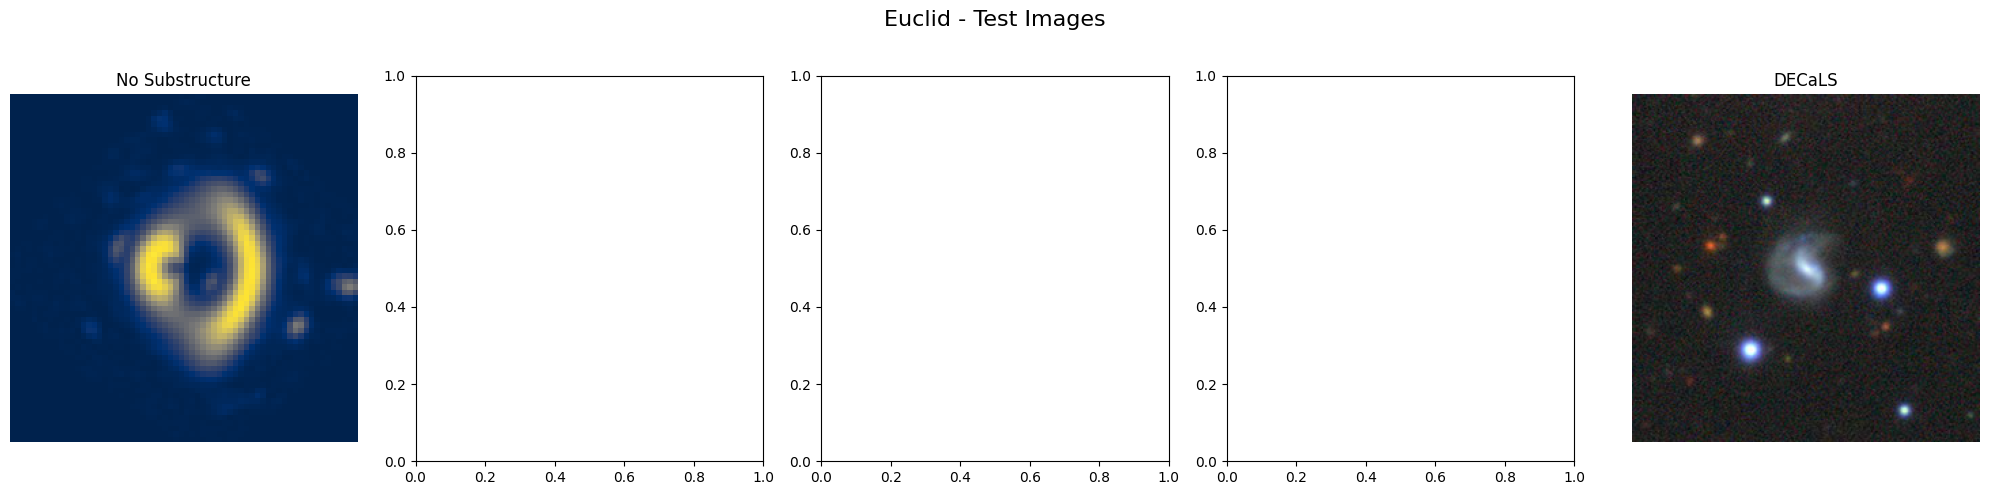

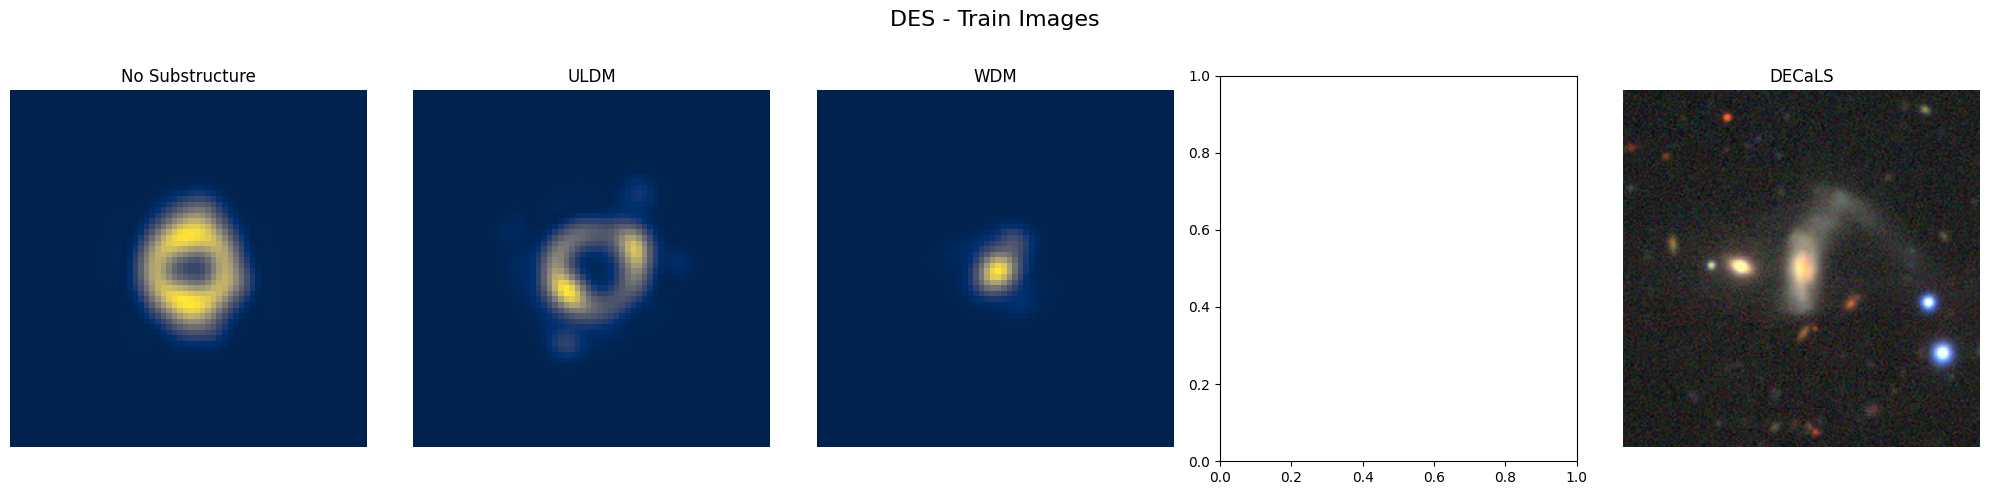

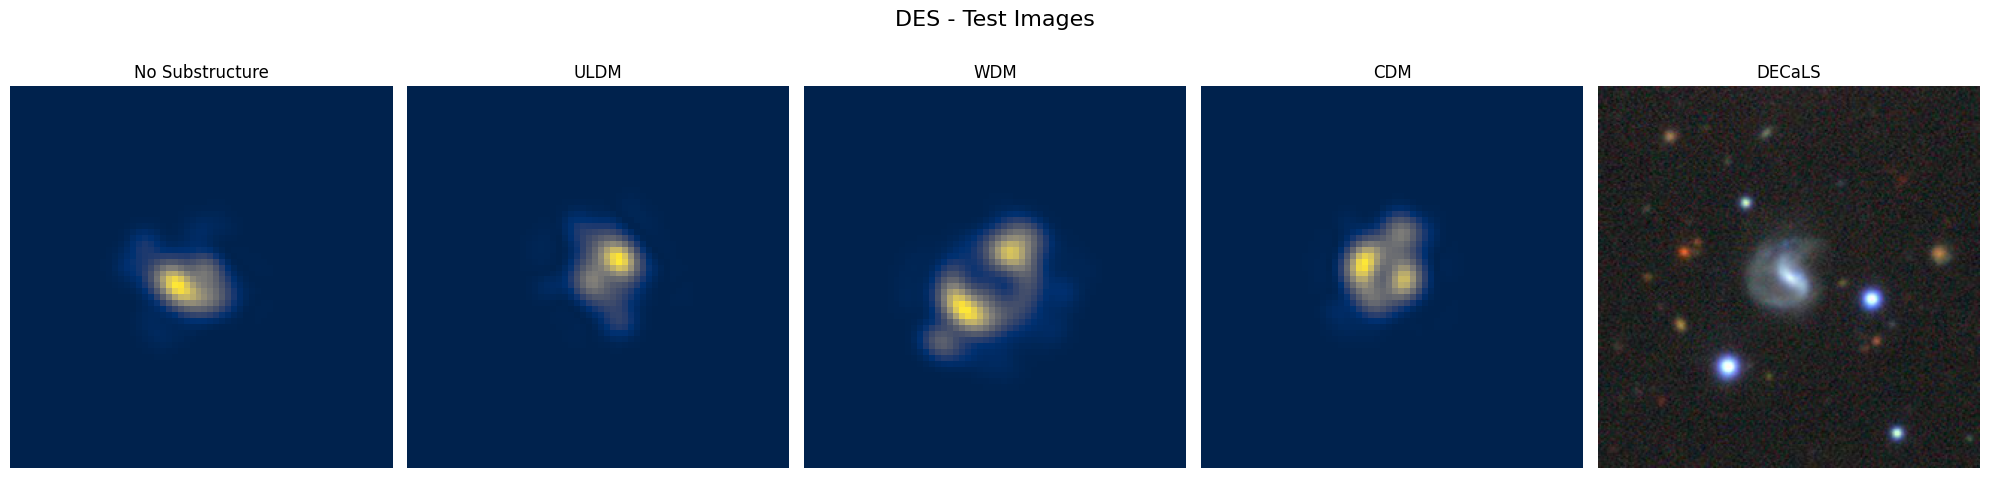

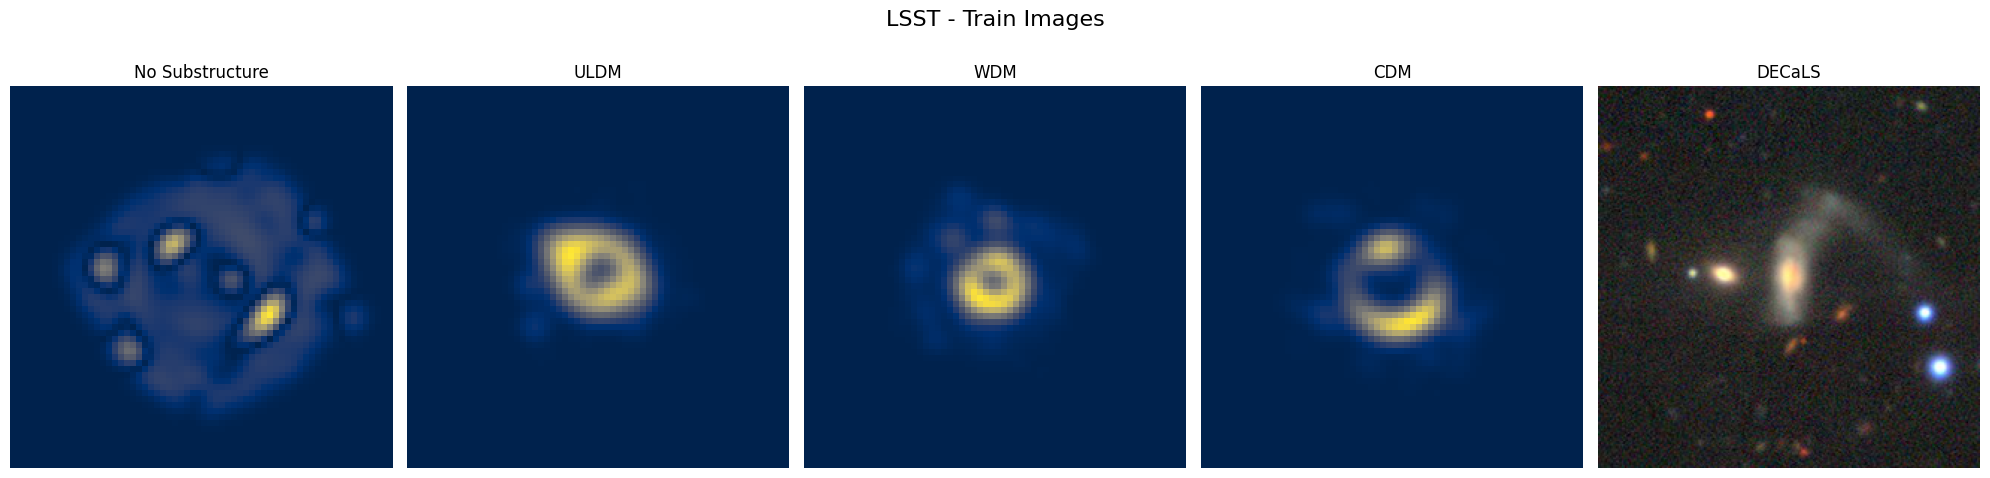

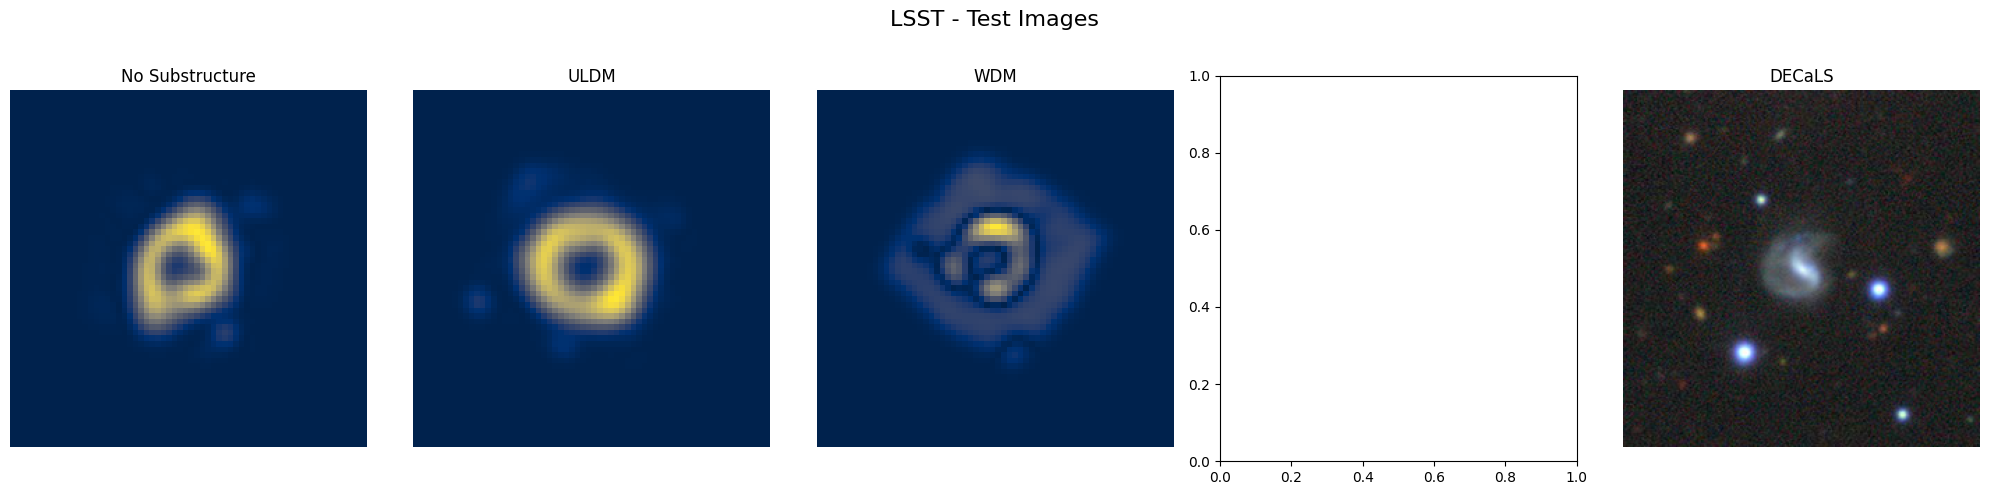

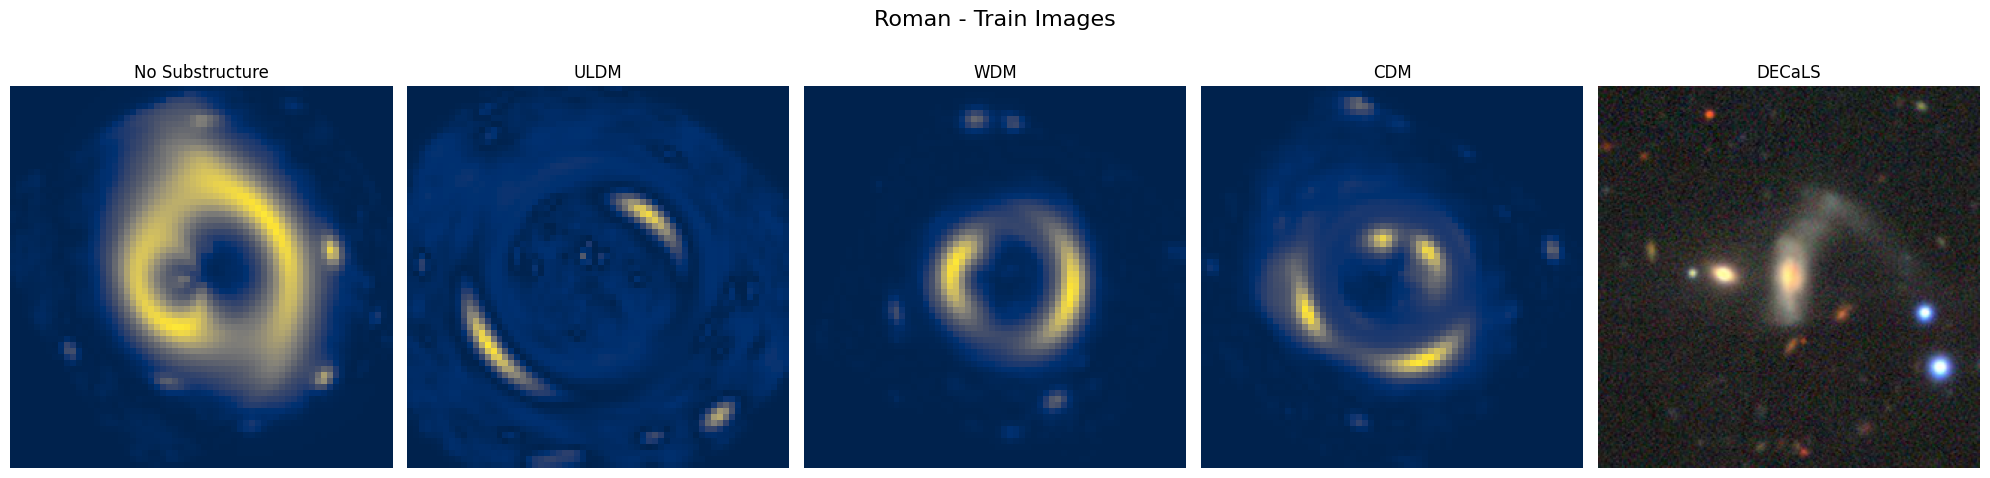

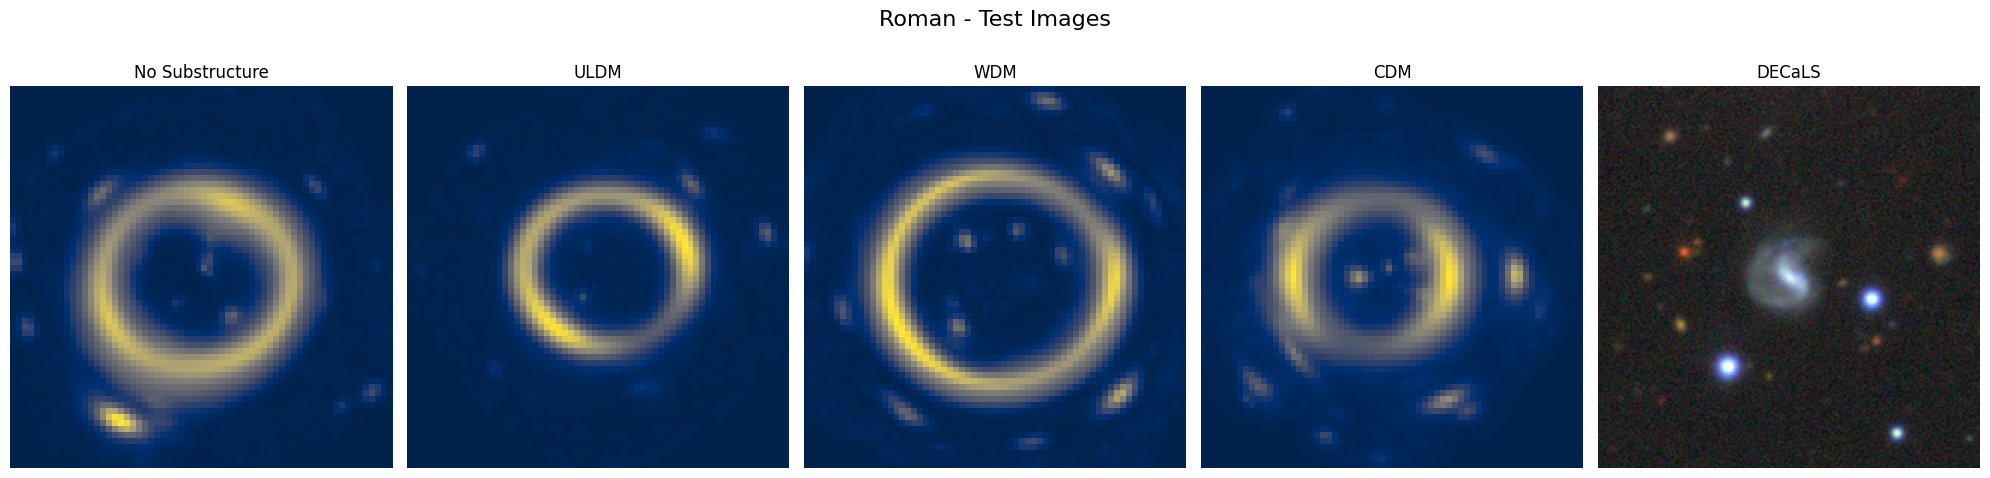

In [42]:
import numpy as np
import matplotlib.pyplot as plt
import h5py

# Define class names (assuming 5 classes: No Substructure, ULDM, WDM, CDM, and DECaLS)
class_names = ["No Substructure", "ULDM", "WDM", "CDM", "DECaLS"]

# Function to load and display images from saved .npy files
def load_and_display_images(data_path_base, instrument_name, decals_images, decals_labels):
    # Paths for train and test data
    train_data_path = f'{data_path_base}{instrument_name}/data_train.npy'
    test_data_path = f'{data_path_base}{instrument_name}/data_test.npy'
    train_labels_path = f'{data_path_base}{instrument_name}/labels_train.npy'
    test_labels_path = f'{data_path_base}{instrument_name}/labels_test.npy'

    # Load the data and labels
    train_data = np.load(train_data_path)
    test_data = np.load(test_data_path)
    train_labels = np.load(train_labels_path)
    test_labels = np.load(test_labels_path)

    # Function to select DECaLS images for train and test
    def get_decals_images(decals_images, start, step):
        return decals_images[start::step]

    # Get alternating DECaLS images for train and test
    decals_train_images = get_decals_images(decals_images, 0, 2)
    decals_test_images = get_decals_images(decals_images, 1, 2)

    # Plotting function for a dataset
    def plot_dataset(data, labels, dataset_name, decals_images, decals_labels):
        num_classes = len(class_names)

        fig, axs = plt.subplots(1, num_classes, figsize=(20, 5))
        fig.suptitle(f"{instrument_name} - {dataset_name} Images", fontsize=16)

        for i in range(num_classes - 1):  # Exclude DECaLS for now
            class_indices = np.where(labels[:, i] == 1)[0]
            if len(class_indices) > 0:
                ax = axs[i]
                ax.imshow(data[class_indices[0]], cmap='cividis')
                ax.axis('off')
                ax.set_title(class_names[i], fontsize=12)

        # Add DECaLS images in the last position
        ax = axs[num_classes - 1]
        if dataset_name == "Train":
            ax.imshow(decals_images[0], cmap='cividis')
        else:
            ax.imshow(decals_images[1], cmap='cividis')
        ax.axis('off')
        ax.set_title(class_names[num_classes - 1], fontsize=12)

        plt.tight_layout(rect=[0, 0, 1, 0.96])
        plt.show()

    # Plot train and test datasets
    plot_dataset(train_data, train_labels, "Train", decals_train_images, decals_labels)
    plot_dataset(test_data, test_labels, "Test", decals_test_images, decals_labels)

# Load DECaLS images and labels
decals_images_path = 'Galaxy10_DECals10samples.h5'
with h5py.File(decals_images_path, 'r') as F:
    decals_images = np.array(F['images'])
    decals_labels = np.array(F['ans'])

# Base path where the data is stored
data_path_base = '/content/'

# Instrument names
instruments = ['Euclid', 'DES', 'LSST', 'Roman']

# Display images for each instrument
for instrument_name in instruments:
    load_and_display_images(data_path_base, instrument_name, decals_images, decals_labels)
